# Where do the clusters change from information to artifactual?

Notes and experiments based on:

* “SciPy hierarchical clustering and dendrogram tutorial”, Jörn’s Blog, <https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/>
* “Determining the number of clusters in a data set”, Wikipedia, <https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set>

The first of these sources writes that “I honestly think it’s a really bad idea to just use any of those methods, unless you know the data you’re working on really really well.”

## Import libraries

In [22]:
from cyr2phon.cyrcluster import *
import matplotlib.pyplot as plt
from matplotlib import gridspec # supports different widths for subplots
from scipy.cluster.hierarchy import inconsistent

## Function to examine height information

Returns Ward linkage object.

In [20]:
def examine_heights(df, ceiling):
    stanzas = df.groupby(level=[0,1])
    c = 0
    for id, lines in stanzas:
        if c < ceiling:
            print(pd.concat([lines["Text"].str.replace(r"<[^>]+?>", ""), 
                             lines[["RhymeWord", "RhymeZone"]]], 
                            axis=1).to_string(index=False)) # diagnostic, suppress index for legibility
            data = lines.copy().filter(regex=r"^token\d_") # only one-hot features
            labelList = list(range(1, len(lines)+1)) # labels are line numbers within stanza
            data.loc[:,"LineNo"] = [2 * n / len(labelList) for n in labelList] # scale to avoid tyranny of proximity
            ward = linkage(data, method="ward")
            print(ward)
            fig = plt.figure(figsize=(15,5))
            gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) # specify subplots of different widths
            ax = fig.add_subplot(gs[0])
            ax.set_title('Ward linkage')
            dendrogram(ward)
            ax = fig.add_subplot(gs[1])
            ax.set_title('Heights')
            # plot lines separately to label them
            x = range(len(ward))
            heights = ward[:, 2]
            nodecounts = ward[:, 3]
            ax.plot(x, heights, label=("height"))
            for i, j in zip(x, heights):
                ax.annotate(round(j, 2), xy=(i, j - 0.2))
            ax.plot(x, nodecounts, label=("number of nodes"))
            for i, j in zip(x, nodecounts):
                ax.annotate(int(j), xy=(i, j + 0.2))
            ax.legend(loc='best')
            plt.show()
        c += 1
        return ward

## Examine sample data

                            Text  RhymeWord RhymeZone
 "Мой дядя самых честных правил,     prAVil      AVil
       Когда не в шутку занемог,    zaNimOk        Ok
        Он уважать себя заставил   zastAVil      AVil
        И лучше выдумать не мог.      NimOk        Ok
        Его пример другим наука;      naUka       Uka
       Но, боже мой, какая скука      skUka       Uka
 С больным сидеть и день и ночь,       inOČ        OČ
        Не отходя ни шагу прочь!       prOČ        OČ
          Какое низкое коварство  kavArstva    Arstva
          Полу-живого забавлять,   zabavLAT        AT
         Ему подушки поправлять,  papravLAT        AT
   Печально подносить лекарство,  LikArstva    Arstva
     Вздыхать и думать про себя:    praSiBA        BA
    Когда же чорт возьмет тебя!"       TiBA        BA
[[ 4.          5.          0.14285714  2.        ]
 [ 9.         10.          0.14285714  2.        ]
 [ 6.          7.          0.14285714  2.        ]
 [12.         13.          0.14285714

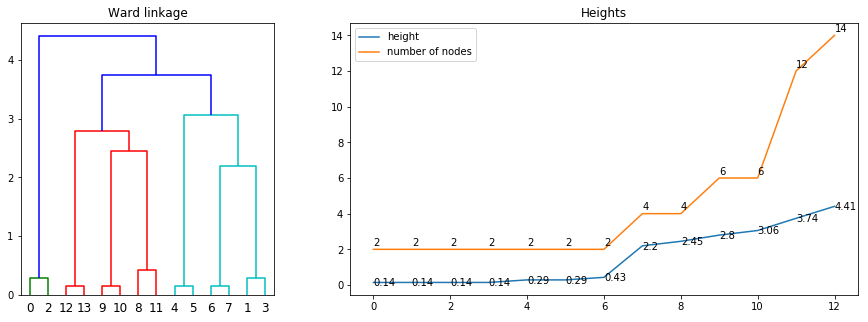

In [21]:
ward = examine_heights(explore("data_samples/eo1.xml"), ceiling=2)

## Inconsistency

[scipy.cluster.hierarchy.inconsistent(*Z, depth=2*)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.inconsistent.html)

*Z* is the 4-column linkage matrix, where the third column is the height and the 4th is the number of clusters
*depth* is the number of previous levels used for comparison

Returns a 4-column matrix with 1) mean height of all links included and 2) standard deviation of the link heights, 3) the number of links included in the calculation, and 4) the inconsistency coefficient.

Caution (Jörn): sensitive to value of *depth*.

In [32]:
print(inconsistent(ward, 2))
print(inconsistent(ward, 100))

[[0.14285714 0.         1.         0.        ]
 [0.14285714 0.         1.         0.        ]
 [0.14285714 0.         1.         0.        ]
 [0.14285714 0.         1.         0.        ]
 [0.28571429 0.         1.         0.        ]
 [0.28571429 0.         1.         0.        ]
 [0.42857143 0.         1.         0.        ]
 [0.87516936 1.14691046 3.         1.152459  ]
 [1.00697277 1.25739794 3.         1.1472239 ]
 [1.79644421 1.44255018 3.         0.69359219]
 [1.79846696 1.49670025 3.         0.83994115]
 [3.1976288  0.48742695 3.         1.11332531]
 [2.8121644  2.21348184 3.         0.72208451]]
[[ 0.14285714  0.          1.          0.        ]
 [ 0.14285714  0.          1.          0.        ]
 [ 0.14285714  0.          1.          0.        ]
 [ 0.14285714  0.          1.          0.        ]
 [ 0.28571429  0.          1.          0.        ]
 [ 0.28571429  0.          1.          0.        ]
 [ 0.42857143  0.          1.          0.        ]
 [ 0.87516936  1.14691046  3.  

The biggest jump seems, not surprisingly, to be at the transition from 2-item clusters to larger ones. 

## Elbow

Percentage of variance explained as a function of total clusters. <https://en.wikipedia.org/wiki/Elbow_method_(clustering)>. Cut at the point where adding another cluster ceases to add significant information about variance.